In [29]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
 
import pandas as pd
pd.set_option('max_colwidth', 200)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import time
import re
import json_lines
import pickle

from model import *
from helper_funcs import *
#from params_dataset_defs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
with open('word_dict.pickle', 'rb') as f:
    word_dict = pickle.load(f)

index_dict = {}
for key, value in word_dict.items():
    index_dict[value] = key


In [38]:
BATCH_SIZE = 64 # 16 in orig paper
EPOCHS = 1
#Tx = 450 #length of input sequence (article)
#Ty = 50 #length of output sequence (abstract)
Tx = 50
Ty = 15
#max_global_oov = 50
max_global_oov = 5
VOCAB_SIZE = len(word_dict)

Loading dataset in json lines form into memory

In [7]:
""" dict values: abstract, dataset, filename, headline, length, md5, offset, published, section, subdomain, text """
t0 = time.time()
data = []
selected_columns = ["text", "abstract"]

for dataset in ["train"]:
    with json_lines.open(f"dataset/sumeczech-1.0-{dataset}.jsonl", 'r') as json_data:
        for line in json_data:
            data.append(line)
        if dataset == "dev": val = pd.DataFrame(data); val = val[selected_columns]
        elif dataset == "oodtest": ood_test = pd.DataFrame(data); ood_test = ood_test[selected_columns]
        elif dataset == "test": test = pd.DataFrame(data); test = test[selected_columns]
        elif dataset == "train": train = pd.DataFrame(data); train = train[selected_columns]
del data
time.time() - t0

35.58034086227417

Converting json lines files to csv for compatibility with tensorflow and easier manipulation

In [6]:
t0 = time.time()
selected_columns = ["abstract", "headline"]

for dataset in ["dev", "train"]:
    json_lines_to_csv_dataset(
        selected_columns, 
        f"dataset/sumeczech-1.0-{dataset}.jsonl", 
        f"dataset_csv/sumeczech_{dataset}.csv", 
        word_dict, VOCAB_SIZE, Tx, Ty, max_global_oov)
    print(f"{dataset} DONE")

time.time() - t0

dev DONE
train DONE


106.40995669364929

In [28]:
Sigma = 0
for point in val_data:
    a, b, c, d = point
    #print(len(b))
    Sigma += np.count_nonzero(b)

Sigma / len(val_data)


9.468149078914893

Retrieving dataset encoded from csv format

In [32]:
t0 = time.time()

val_data = read_csv_dataset(f"dataset_csv/sumeczech_dev.csv", word_dict, VOCAB_SIZE, Tx, Ty)
train_data = read_csv_dataset(f"dataset_csv/sumeczech_train.csv", word_dict, VOCAB_SIZE, Tx, Ty)

time.time() - t0

33.26148223876953

Creating dictionary

In [11]:
t0 = time.time()
#creating a dictionary from train
word_dict = {}
reg = r"[\w']+|[.,!?;]"

for i in range(train.shape[0]):
    for word in re.findall(reg, train.iloc[i]['text']) + re.findall(reg, train.iloc[i]['abstract']):
        word = word.lower()

        if word not in word_dict.keys(): word_dict[word] = 0

        word_dict[word] += 1

vocab_size = 50000

word_dict = {k : v for k, v in sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[:vocab_size]} #sorting keys by count of occurences 
for i, (word, _) in enumerate(word_dict.items()): word_dict[word] = i + 1 + 4 #replacing count values by unique token values
#special tokens
word_dict["<sos>"] = 1 # start of sequence !later used in model
word_dict["<eos>"] = 2 # end of sequence
word_dict["<unk>"] = 3 # unknown token/word
word_dict["<pad>"] = 0 # padding

with open('word_dict.pickle', 'wb') as f:
    pickle.dump(word_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

time.time() - t0

556.8967771530151

In [9]:
for key, value in list(word_dict.items())[0:10]: #removing number > x from dict?, jména politiků,
    print(value, "\t", key)

5 	 ,
6 	 .
7 	 a
8 	 v
9 	 se
10 	 na
11 	 je
12 	 že
13 	 s
14 	 to


Opening the dictionary

## Determining lengths of input and output sequences (Tx and Ty)
setting Tx and Ty on heuristicaly from graph information

In [ ]:
text_lens = []
abstract_lens = []

for i in range(val.shape[0]):
    text_lens.append(len(re.findall(r"[\w]+",val.iloc[i]['text'])))
    abstract_lens.append(len(re.findall(r"[\w]+", val.iloc[i]['abstract'])))

(0, 2000)

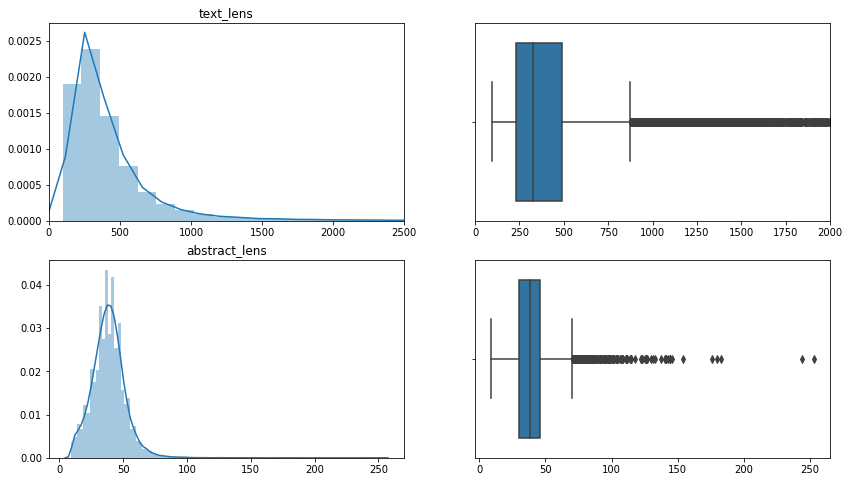

In [54]:
fig, ax = plt.subplots(2,2, figsize=(7,4))
sns.distplot(text_lens, bins=100, ax=ax[0, 0])
sns.distplot(abstract_lens, bins=100, ax=ax[1, 0])

sns.boxplot(text_lens, ax=ax[0, 1])
sns.boxplot(abstract_lens, ax=ax[1, 1])

ax[0, 0].set_title("text_lens")
ax[1, 0].set_title("abstract_lens")

ax[0, 0].set_xlim([0, 2500])
ax[0, 1].set_xlim([0, 2000])

In [57]:
print(f"median text len: {text_lens[len(text_lens) // 2]}")
print(f"median abstract len: {abstract_lens[len(abstract_lens) // 2]}")

median text len: 334
median abstract len: 48


## Training

In [ ]:
""" 
Ideas:
try shorter input seq if attention over words is not enough
add attention over sentences

Notes:
dimensions batch x examples x features

change h_units, a_units
try adding bilstm layers
investigate why does first pass takes so long
"""

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
sns.distplot(oov_cnts, ax=ax[0])
sns.boxplot(oov_cnts, ax=ax[1])
print("5num summary: ", np.min(oov_cnts), np.percentile(oov_cnts, [25, 50, 55]), np.max(oov_cnts))

5num summary:  0 [15. 23. 24.] 50


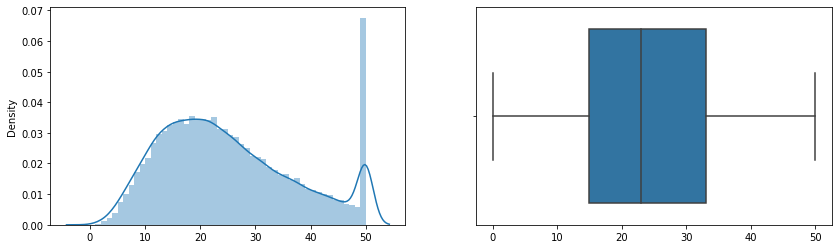

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
sns.distplot(oov_cnts, ax=ax[0])
sns.boxplot(oov_cnts, ax=ax[1])
print("5num summary: ", np.min(oov_cnts), np.percentile(oov_cnts, [25, 50, 55]), np.max(oov_cnts))

In [16]:
    def ext_to_unk(index):
        if index >= VOCAB_SIZE: #############..greater tha equals??
            return word_dict["<unk>"]
        else: return index

In [32]:
X_batch_ext = []; y_batch = []; oov_cnts = []; oov_vocabs = []; X_batch = []; y_batch_teacher_force = []
                
for i in range(len(val_data)):
                     X_ext, y_ext, oov_cnt, oov_vocab = val_data[i]

                     #X_batch.append(list(map(ext_to_unk, X_ext)))
                     #y_batch_teacher_force.append(list(map(ext_to_unk, y_ext)))
                     #X_batch_ext.append(X_ext)
                     #y_batch.append(y_ext)
                     oov_cnts.append(oov_cnt) 
                     #oov_vocabs.append(oov_vocab)

In [18]:
X_batch = np.array(X_batch) #X_batch_ext = np.array(X_batch_ext)
X_batch_indeces_ext = np.array(X_batch_ext).flatten()
y_batch_teacher_force = np.array(y_batch_teacher_force)
y_batch = np.array(y_batch, np.uint16)

In [44]:
val_data = val_data[:1000]

In [40]:
model = TextSummarizer(Tx, Ty, BATCH_SIZE, VOCAB_SIZE, 
                        embedding_dim=128, a_units=128, h_units=128, word_dict=word_dict, index_dict=index_dict, max_global_oov=max_global_oov)

In [45]:
A = tf.Variable([[1, 2, 3], [1, 2, 3]])
B = tf.nn.softmax(A, -1)

NotFoundError: Could not find valid device for node.
Node:{{node Softmax}}
All kernels registered for op Softmax :
  device='XLA_GPU'; T in [DT_FLOAT, DT_DOUBLE, DT_BFLOAT16, DT_HALF]
  device='XLA_CPU'; T in [DT_FLOAT, DT_DOUBLE, DT_BFLOAT16, DT_HALF]
  device='XLA_CPU_JIT'; T in [DT_FLOAT, DT_DOUBLE, DT_BFLOAT16, DT_HALF]
  device='XLA_GPU_JIT'; T in [DT_FLOAT, DT_DOUBLE, DT_BFLOAT16, DT_HALF]
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_HALF]
  device='GPU'; T in [DT_DOUBLE]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_HALF]
 [Op:Softmax]

In [41]:
history = model.fit(epochs=EPOCHS, 
            train_data=train_data,
            val_data=val_data
            )

...
epoch: 1         stage: train        batch: 032/13556         [>........................] (0.2%)	loss: 8.31608	acc: 0.007	topkacc: 0.022	t+:1:14s

KeyboardInterrupt: 

Text(0.5, 1.0, 'val_acc')

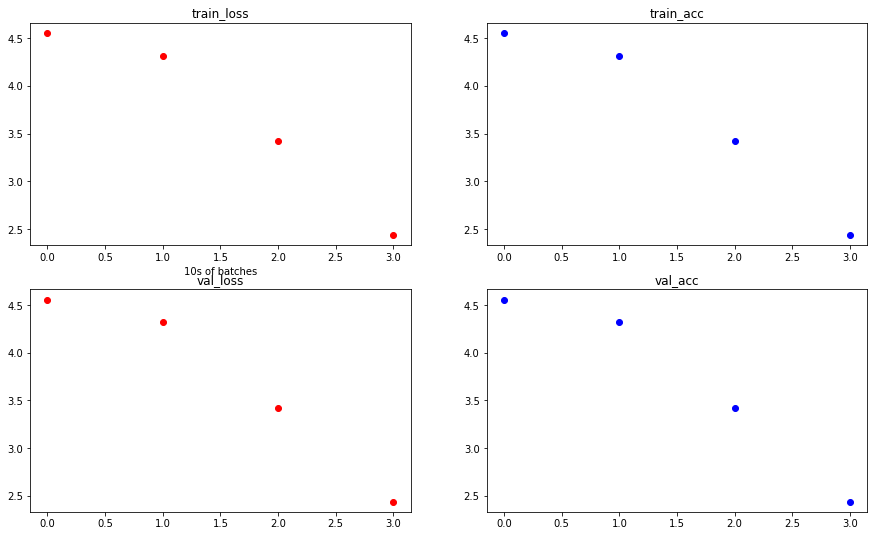

In [77]:
fig, ax = plt.subplots(2,2, figsize=(15,9))
ax[0, 0].plot(range(len(history['train_loss'])), history['train_loss'], 'ro', label='val_acc')
ax[0, 1].plot(range(len(history['train_acc'])), history['train_acc'], 'bo')
ax[1, 0].plot(range(len(history['val_loss'])), history['val_loss'], 'ro')
ax[1, 1].plot(range(len(history['val_acc'])), history['val_acc'], 'bo')

ax[0, 0].set_title("train_loss")
ax[0, 0].set_xlabel("10s of batches")
ax[0, 1].set_title("train_acc")
ax[1, 0].set_title("val_loss")
ax[1, 1].set_title("val_acc")